**Install necessary features for the implementation**

In this code instead of the whole RSNA intracranial hemorage dataset we have used the clean dataset of Howard, https://www.kaggle.com/jhoward/rsna-hemorrhage-jpg

In [90]:
!pip uninstall -y kaggle  #to make sure to install the version that we are working with
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!pip install kaggleDownloader

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.6-py3-none-any.whl
Kaggle API 1.5.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
!pip install fastai2
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
# from kaggleDownloader import get_dataset
import os
from google.colab import drive

In [93]:
os.environ["KAGGLE_USERNAME"] = "samanesharifi"
os.environ["KAGGLE_KEY"] = "e1ef4940d42730683c90cbf8c54dd257"

In [94]:
# download kaggle.json and upload it on drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [95]:
# copy kaggle.json to cwd
!cp drive/My\ Drive/kaggle.json /content

In [96]:
# !kaggle datasets download -d jhoward/rsna-hemorrhage-jpg --force

In [97]:
# !mkdir drive/My\ Drive/rsna-data
# %mv rsna-hemorrhage-jpg.zip drive/My\ Drive/
# %cd drive/My\ Drive

In [98]:
# from zipfile import ZipFile
# with ZipFile('rsna-hemorrhage-jpg.zip', 'r') as archive:
#   archive.extractall('rsna-data')

In [99]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
import pydicom

In [101]:
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import pydicom
import glob
import pandas as pd

# im = np.array(Image.open('/content/drive/MyDrive/rsna-data/train_jpg/train_jpg/ID_367091856.jpg').convert('L')) 
# print(im.shape)
# plt.imshow(im, cmap=plt.cm.bone);

**End of the Setup**

***data_exploration***

In [102]:
import seaborn as sns
from pathlib import Path
from fastai2.vision import *
from fastai2.medical import *


from fastai.vision.all import *

In [103]:
trn_path = Path('/content/drive/MyDrive/rsna-data/train_jpg/train_jpg/')
csv_path = Path('/content/drive/MyDrive/rsna-data/meta/meta/')

In [104]:
fn = get_image_files(trn_path)
len(fn)

23231

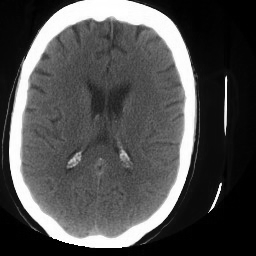

In [105]:
img = PILImage.create(fn[12], mode = 'L')
img

In [106]:
def read_image(x, mode = 'L'): return PILImage.create(x, mode = mode)
def read_images(imgs, **kwargs): return L([read_image(x, **kwargs) for x in imgs])

In [107]:
trn_imgs = read_images(fn[:200])
np.random.shuffle(trn_imgs)

In [108]:
def show_batch(x, nrows = 5, ncols = 5, title = None):
    """
    Read a list of images, and display them
    """
    fig=plt.figure(figsize=(9, 9))
    if title: plt.title(title)
    for i in range(1, ncols*nrows +1):
        ds = x[i]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(ds, cmap=plt.cm.bone)
        fig.add_subplot


Have a Look at the images:

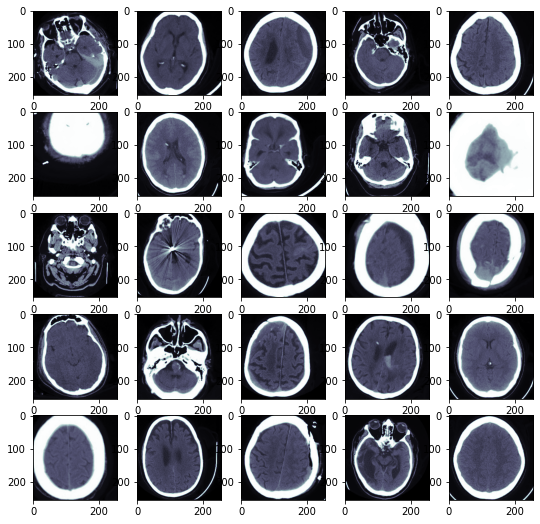

In [109]:
show_batch(trn_imgs)

We see that some of the images are not of the brain but of teeth. Some other images are mostly black because they are images of above or below the brain and hence contain no useful information at all. We will remove all such images.

In [110]:
path_meta=root2 = Path('/content/drive/MyDrive/rsna-data/meta/meta/')

In [111]:
df = pd.read_feather(root2 / 'comb.fth')
df.head()

,BitsAllocated,BitsStored,Columns,HighBit,ImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,...,img_mean,img_min,img_pct_window,img_std,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,16,16,512,15,1.0,0.0,0.0,0.0,0.927184,-0.374607,...,35.112926,-2000,0.164139,1166.720843,0,0,0,0,0,0
1,16,12,512,11,1.0,0.0,0.0,0.0,1.000000,0.000000,...,234.549896,0,0.076015,392.132243,0,0,0,0,0,0
2,16,16,512,15,1.0,0.0,0.0,0.0,1.000000,0.000000,...,482.248981,0,0.241489,571.235614,1,0,1,1,0,0
3,16,16,512,15,1.0,0.0,0.0,0.0,0.927184,-0.374607,...,106.237759,-2000,0.242466,1253.462451,1,0,1,0,0,0
4,16,12,512,11,1.0,0.0,0.0,0.0,1.000000,0.000000,...,536.799244,9,0.345436,568.654045,0,0,0,0,0,0


In [112]:
df.shape

(674257, 48)

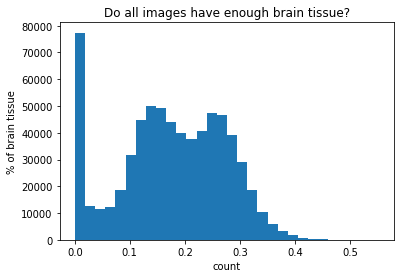

In [113]:
plt.hist(df['img_pct_window'], 30)
plt.xlabel('count')
plt.ylabel('% of brain tissue')
plt.title('Do all images have enough brain tissue?');

In [114]:
discarded = df[df['img_pct_window'] < 0.2] 
# Checking the discarded once

In [115]:
dimgs = list(discarded['SOPInstanceUID'].values)
len(dimgs)

386114

In [116]:
df_comb = pd.read_feather(path_meta/'comb.fth').set_index('SOPInstanceUID')
df_tst  = pd.read_feather(path_meta/'df_tst.fth').set_index('SOPInstanceUID')
df_samp = pd.read_feather(path_meta/'wgt_sample.fth').set_index('SOPInstanceUID')
labels = pd.read_feather(path_meta/'labels.fth')

# bins = (path_meta/'bins.pkl').load()
bins = load_pickle(path_meta/'bins.pkl')

In [117]:
df =pd.read_feather(path_meta/'df_trn.fth').set_index('SOPInstanceUID')
df.head().T

SOPInstanceUID,ID_352e89f1c,ID_3cf4fb50f,ID_2a8702d25,ID_66891ac22,ID_54f412d54
BitsAllocated,16,16,16,16,16
BitsStored,16,12,16,16,12
Columns,512,512,512,512,512
HighBit,15,11,15,15,11
ImageOrientationPatient,1.0,1.0,1.0,1.0,1.0
ImageOrientationPatient1,0.0,0.0,0.0,0.0,0.0
ImageOrientationPatient2,0.0,0.0,0.0,0.0,0.0
ImageOrientationPatient3,0.0,0.0,0.0,0.0,0.0
ImageOrientationPatient4,0.927184,1.0,1.0,0.927184,1.0
ImageOrientationPatient5,-0.374607,0.0,0.0,-0.374607,0.0


In [118]:
df.shape

(674258, 41)

Checking the Null Values:

In [119]:
df.isnull().sum()

BitsAllocated                        0
BitsStored                           0
Columns                              0
HighBit                              0
ImageOrientationPatient              0
ImageOrientationPatient1             0
ImageOrientationPatient2             0
ImageOrientationPatient3             0
ImageOrientationPatient4             0
ImageOrientationPatient5             0
ImagePositionPatient                 0
ImagePositionPatient1                0
ImagePositionPatient2                0
Modality                             0
MultiImageOrientationPatient         0
MultiImagePositionPatient            0
MultiPixelSpacing                    0
MultiWindowCenter               341679
MultiWindowWidth                341679
PatientID                            0
PhotometricInterpretation            0
PixelRepresentation                  0
PixelSpacing                         0
PixelSpacing1                        0
RescaleIntercept                     0
RescaleSlope             

Most columns don't have any null values. We can drop the columns that have too many missing values. Let's look at the labels as well.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


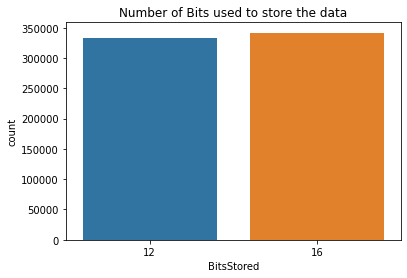

In [120]:
plt.title('Number of Bits used to store the data')
sns.countplot(df['BitsStored']);

**َAdding Data Augmentation**

The first step in training a good deep learning model is to get enough data. However, that's not always possible. What is possible though, it to apply some transformations on the data.

What we do is, instead of feeding the model with the same pictures every time, we do small random transformations (a bit of rotation, zoom, translation, etc…) that doesn’t change what’s inside the image (for the human eye) but changes its pixel values. Models trained with data augmentation will then generalize better. Data augmentation is also useful in situations when you have a relatively small number of training samples.

A detailed article on data augmentation can be found here

Let's try some augmentations on our dataset and see if they make sense.

In [121]:
base = Path('/content/drive/MyDrive/rsna-data')

In [122]:
fn = get_image_files(base/'train_jpg/train_jpg/')
len(fn)

23231

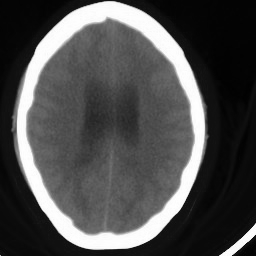

In [123]:
n = np.random.randint(0,1000)
img = PILImage.create(fn[n], mode = 'L')
img

Crop -- not useful

It is generally a good idea to use something like CentreCrop or RandomCrop for image classification. However, we have already cropped our images during data cleaning and removed most of the background. Also, we might accidentally crop out useful information. Hence, we won't be using any crop or zoom transformations on our images


Flip -- useful

The first transformation that we will try on our images is flipping or mirror image. The bleed can occur on either side hence this transformation won't change the meaning of any image.


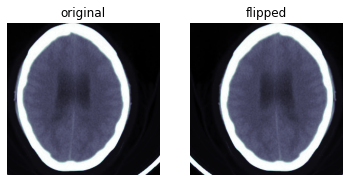

In [124]:
_,axs = subplots(1,2)
show_image(img, ctx=axs[0], title='original', cmap = plt.cm.bone)
show_image(img.flip_lr(), ctx=axs[1], title='flipped', cmap = plt.cm.bone);



Rotation -- useful

As we've seen from the sample images, not all images are straight. Some of them have a slight tilt. Hence we will randomly rotate some images from -15 to 15 degrees


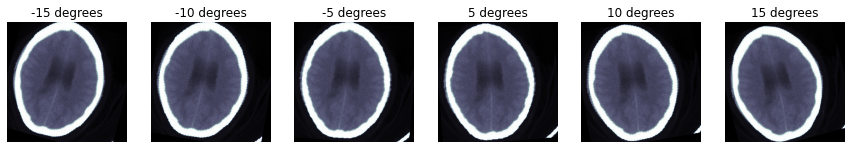

In [125]:
thetas = [-15,-10,-5,5,10,15]
_,axs = plt.subplots(1,6, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(img.rotate(thetas[i]), ctx=ax, title=f'{thetas[i]} degrees', cmap = plt.cm.bone)



Dihedral -- not useful

Dihedral includes a number of flips and although we can force the ones we want, we will just use them separately (eg flip)


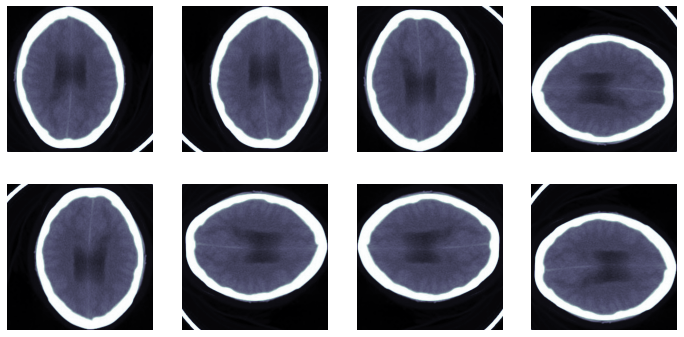

In [126]:
_,axs = subplots(2, 4)
for i,ax in enumerate(axs.flatten()):
    show_image(img.dihedral(i), ctx=ax, cmap=plt.cm.bone)


Blur -- useful

If patients move during a CT scan, there can be artifacts in the scan. Those are really bad scans, however, even in the good ones, there can be a bit of blur. We will not introduce too much blur though.


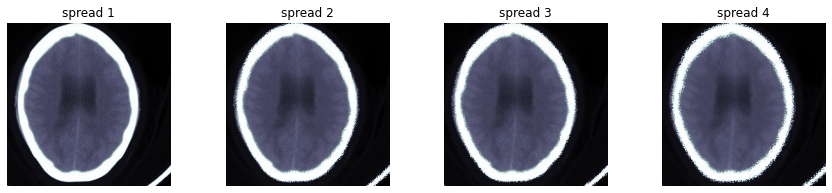

In [127]:
fig,axs = plt.subplots(1,4, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(img.effect_spread(i+1), ctx=ax, title=f'spread {i+1}', cmap=plt.cm.bone)


Warp -- not useful

All the CT scans will have the same perspective and we don't want to change that.
Brightness -- not useful

We don't want to mess around with the brightness either. All scans will have similar brightness.
Resize - Progressive image resizing

The images in our dataset are of size (256,256). Progressive image resizing is a really useful technique for training deep learning models. In this technique, we train our model on smaller size images and gradually increase the size. This helps them train better.


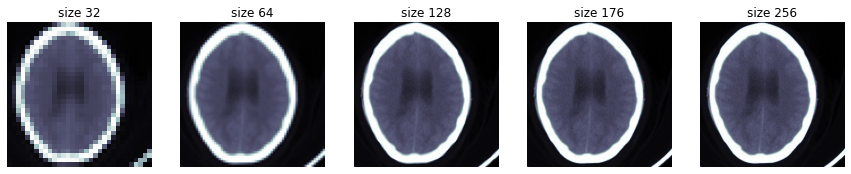

In [128]:
st = [(32,32),(64,64),(128,128),(176,176), (256,256)]
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_image(img.resize(st[i]), ctx=ax, title=f'size {st[i][0]}', cmap=plt.cm.bone)

In [129]:
!pip install fastai2
!pip install fastai2>=0.0.11 graphviz ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn azure-cognitiveservices-search-imagesearch sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [130]:
fn = get_image_files(trn_path)
len(fn)

23231

In [131]:
labels = pd.read_csv('/content/drive/MyDrive/rsna-data/meta/meta_csv/labels.csv')

labels.head()


,Unnamed: 0,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,2,ID_00008ce3c.jpg,0,0,0,0,0,0
1,4,ID_0000aee4b.jpg,0,0,0,0,0,0
2,11,ID_0002003a8.jpg,0,0,0,0,0,0
3,12,ID_0002081b6.jpg,1,0,1,0,0,0
4,19,ID_00027cbb1.jpg,0,0,0,0,0,0


In [132]:
labels = labels.iloc[:,1:3]
labels.head()

,ID,any
0,ID_00008ce3c.jpg,0
1,ID_0000aee4b.jpg,0
2,ID_0002003a8.jpg,0
3,ID_0002081b6.jpg,1
4,ID_00027cbb1.jpg,0


    There is a list of images in the given path, and their corresponding labels in a csv file
    Split these images into train and validation set randomly.
    Label the data using the csv file shown. (or df = data frame)
    Add a test set. (This step is optional)
    Set the size of the images and apply various transforms on them.
    And finally create a data bunch. (This can be thought of as a format in which fastai stores images)

In [133]:
dls = ImageDataLoaders.from_df(labels, trn_path, bs = 256, seed = 42)

In [134]:
len(dls.train_ds), len(dls.valid_ds)

(18585, 4646)

In [135]:
dls.bs

256

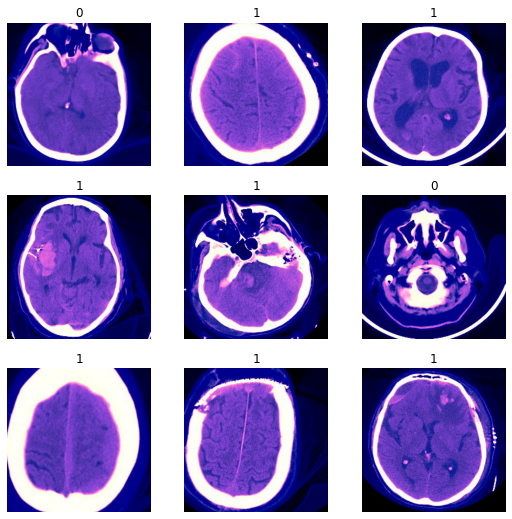

In [136]:
dls.show_batch()

**Implementing CNN after Data augmentation**

In [137]:
learn = vision_learner(dls, resnet18, pretrained=False, metrics=[error_rate, accuracy], model_dir='/kaggle')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


We use Leslie Smith's famous learning rate finder to give us a good suggestion about the LR. Learn more about why you need a good learning rate

SuggestedLRs(valley=0.0002754228771664202)

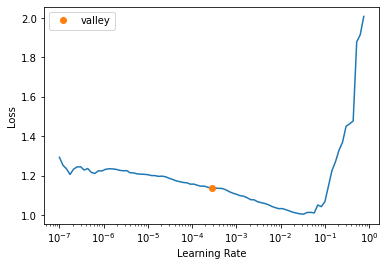

In [138]:
learn.lr_find()

In [139]:
learn.fit_one_cycle(2, lr_max = 3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.719406,0.536340,0.294016,0.705984,00:19
1,0.531589,0.442980,0.206199,0.793801,00:19


In [140]:
learn.unfreeze()

SuggestedLRs(valley=6.30957365501672e-05)

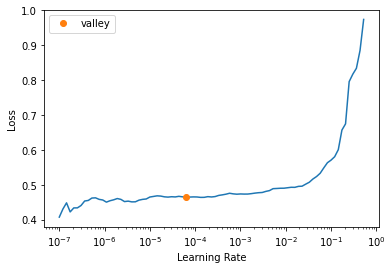

In [141]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max = 1e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.425730,0.420067,0.191347,0.808653,00:19
1,0.424209,0.419178,0.190917,0.809083,00:19
2,0.424038,0.420519,0.192424,0.807576,00:19


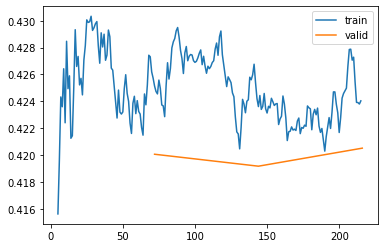

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save("/result")

Path('/content/drive/MyDrive/Thesis 4 - CNN - data augmentation/result of baseline.pth')

This time we use the pretrained weights. Learn more about why you should be using transfer learning here

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy], model_dir='/kaggle')

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0004786300996784121)

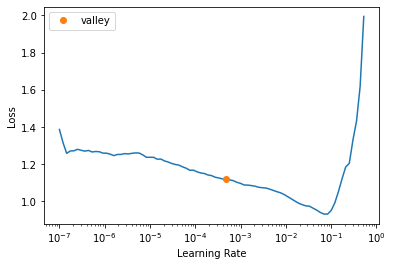

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.593427,0.391603,0.172622,0.827378,00:32
1,0.394701,0.363880,0.157985,0.842015,00:32


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=3.630780702224001e-05)

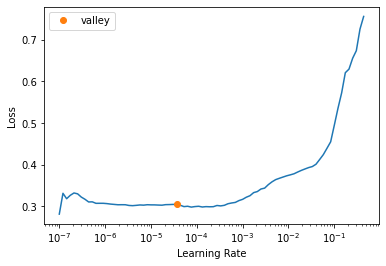

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.305815,0.356760,0.153896,0.846104,00:37
1,0.288224,0.352618,0.152389,0.847611,00:37
2,0.271471,0.352037,0.151528,0.848472,00:37


In [ ]:
learn.save("result-pre_baseline-stage-1")

Path('/content/drive/MyDrive/Thesis 4 - CNN - data augmentation/result of baseline/result-pre_baseline-stage-1.pth')

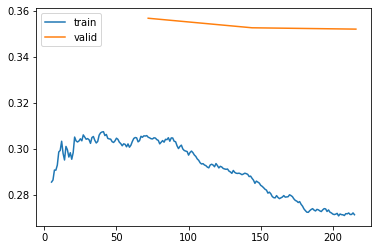

In [ ]:
learn.recorder.plot_loss()

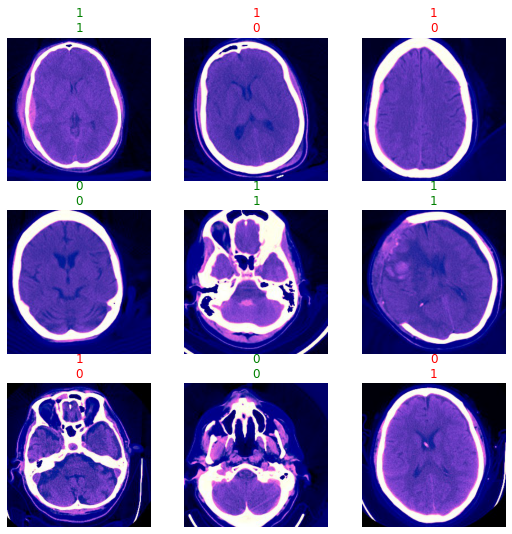

In [ ]:
learn.show_results()

In [ ]:
learn.save("/content/drive/MyDrive/Thesis 4 - CNN - data augmentation/result of baseline")

Path('/content/drive/MyDrive/Thesis 4 - CNN - data augmentation/result of baseline.pth')

In [ ]:
learn.recorder.plot_loss()

Sequential (Input shape: 256 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 128 x 12 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 64 x 64  
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 256 x 64 x 64 
Conv2d                                    16384      True      
BatchNorm2d                       